https://www.pmorgan.com.au/tutorials/crostons-method/

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.handlers import scope
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

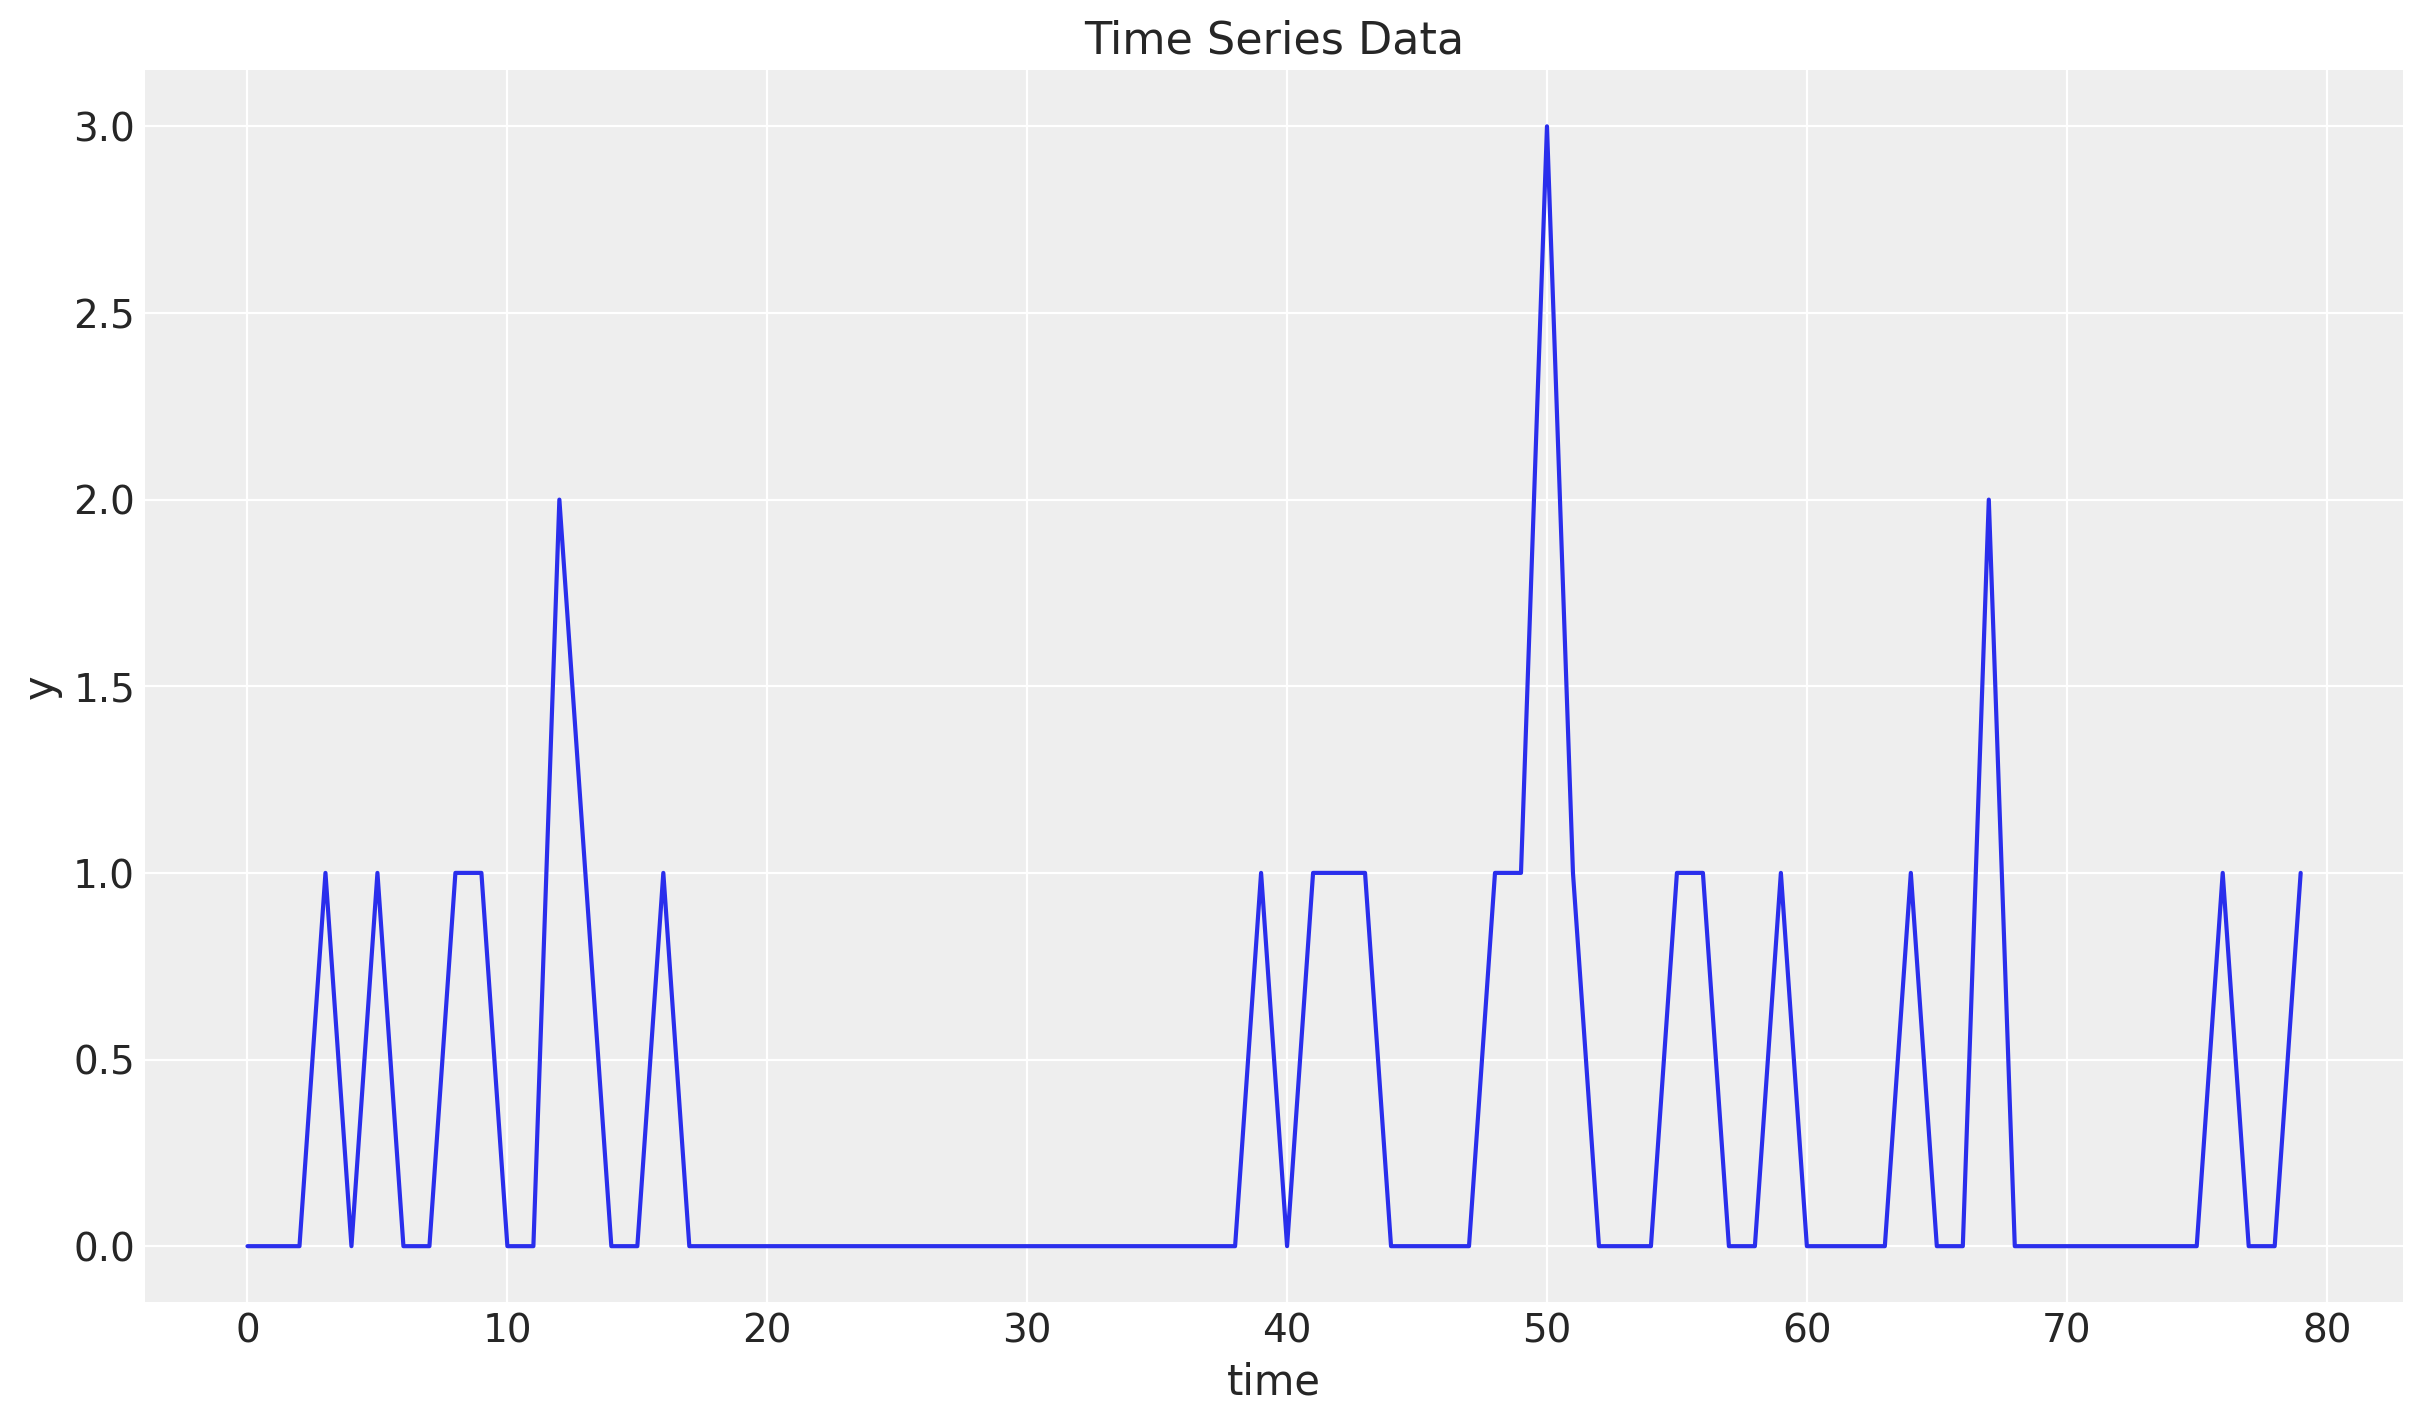

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

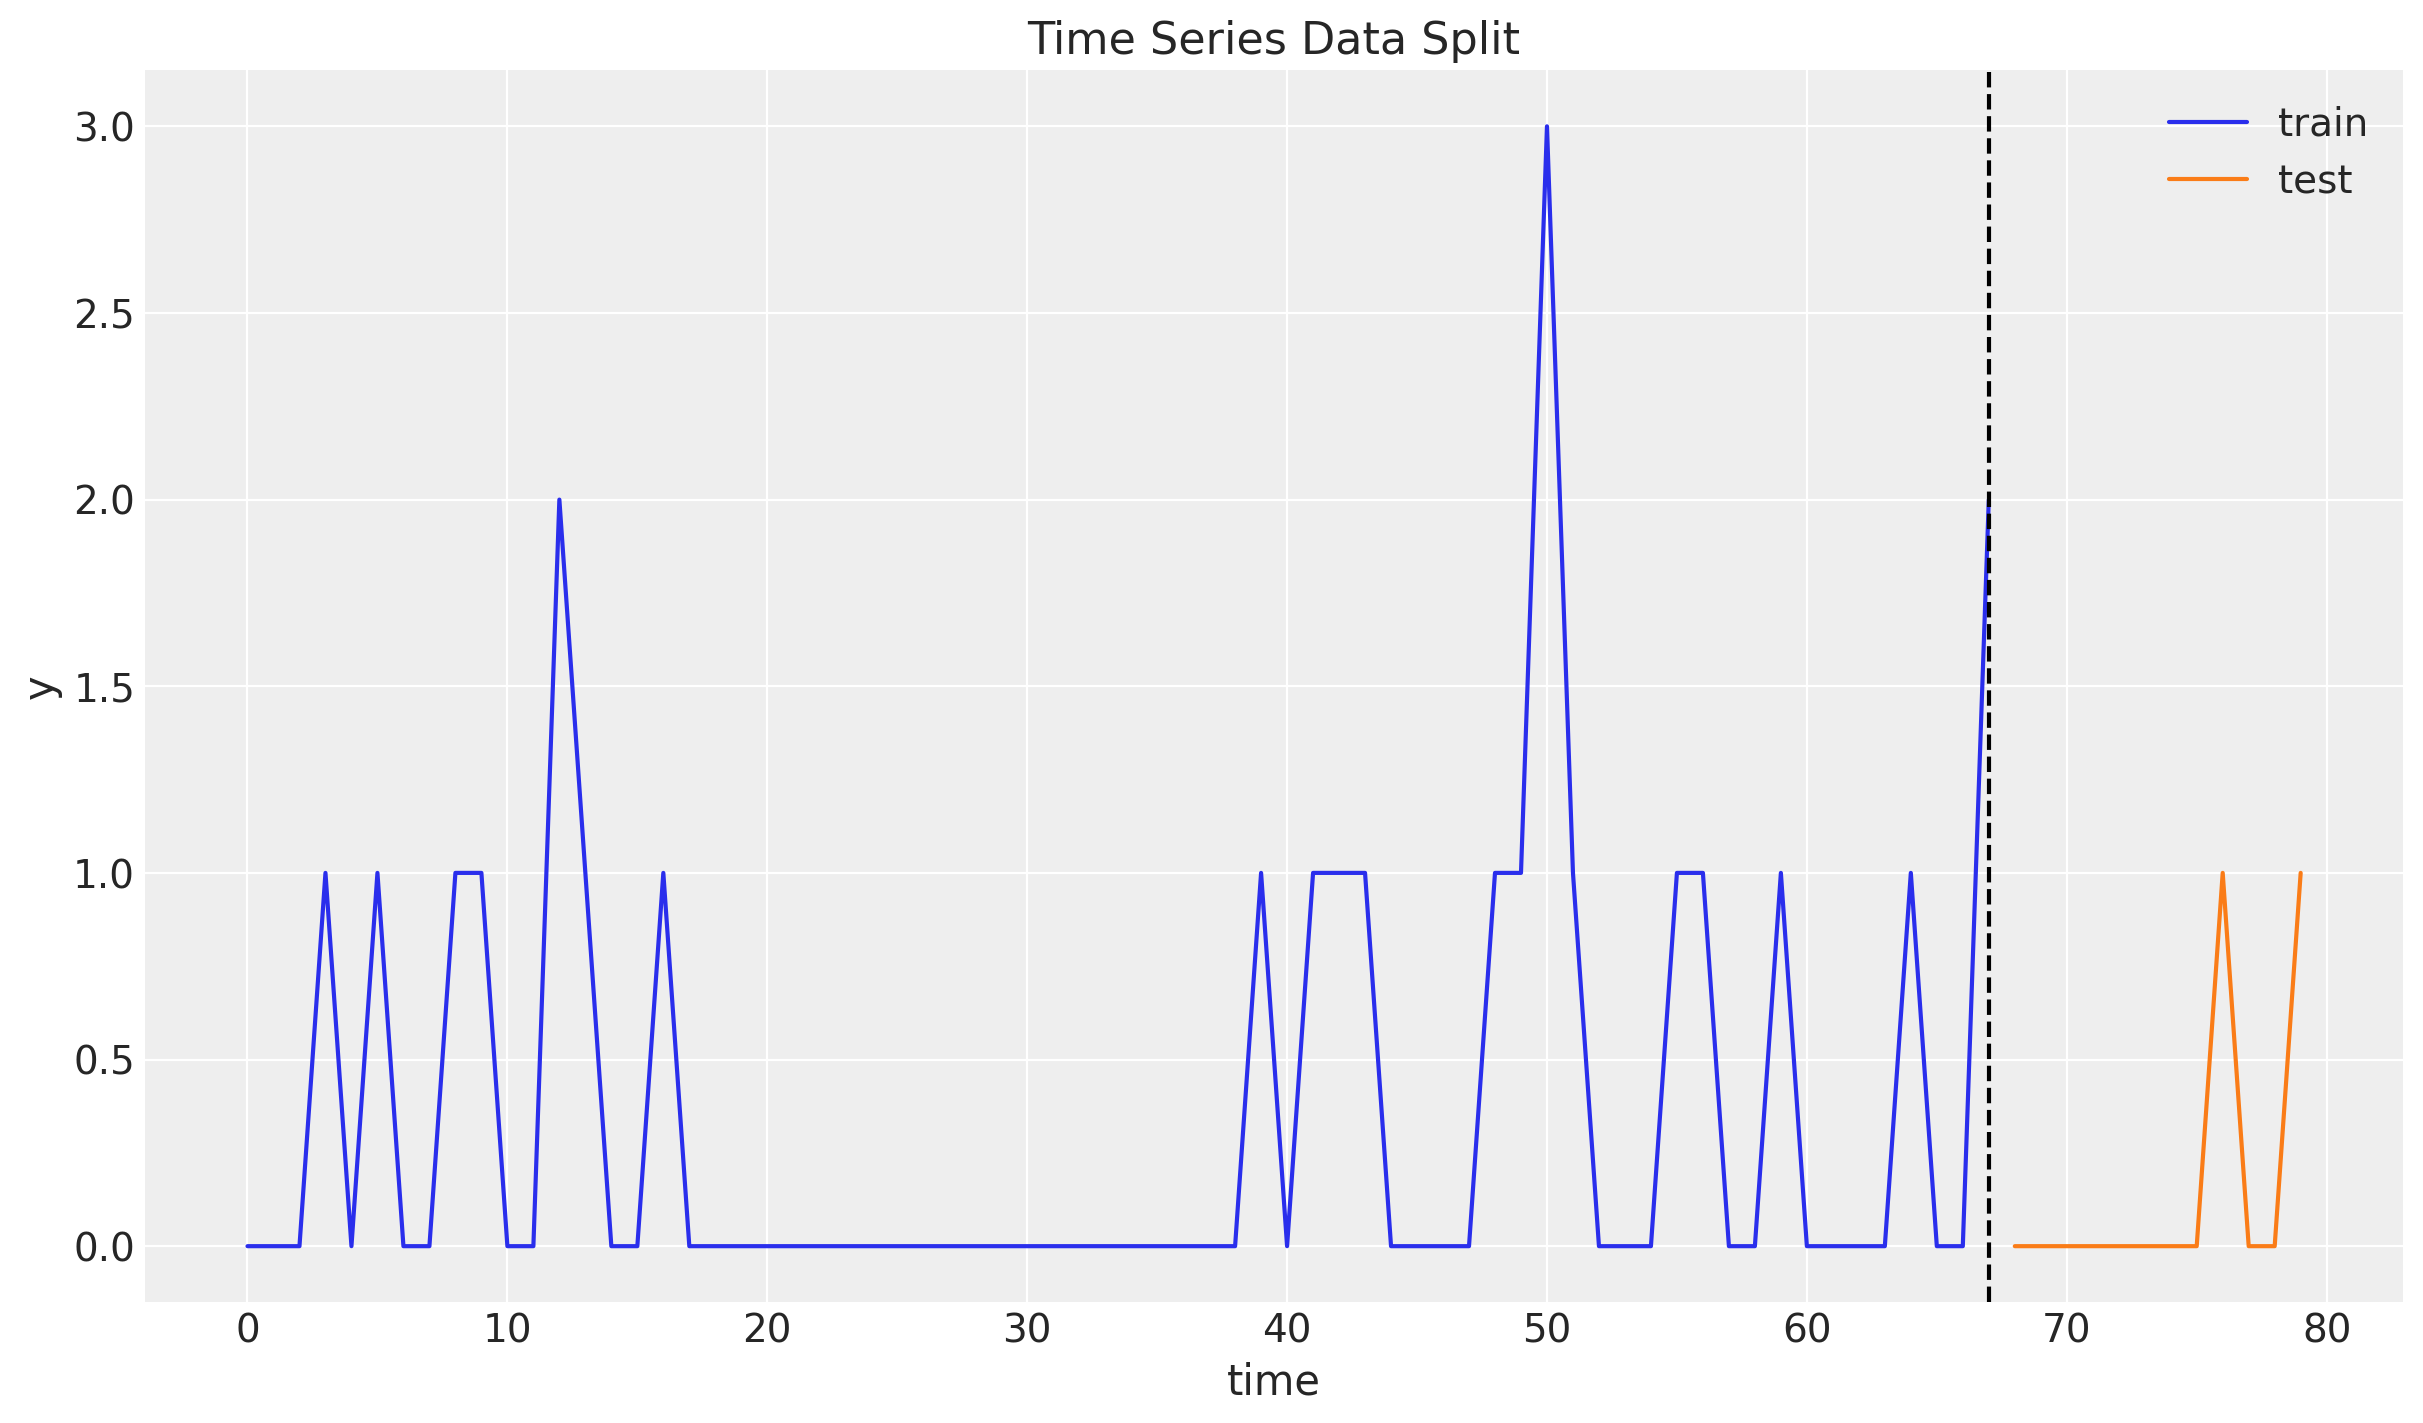

In [3]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

In [4]:
print(f"y: {y}")

y: [0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 2. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 3. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1.]


In [5]:
z = y_train[y_train != 0]

print(f"Demand: {z}")

Demand: [1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2.]


In [6]:
p_idx = jnp.flatnonzero(y_train).astype(jnp.float32)
p = jnp.diff(p_idx, prepend=-1)

print("Index: ", p_idx)
print("Period, p: ", p)

Index:  [ 3.  5.  8.  9. 12. 13. 16. 39. 41. 42. 43. 48. 49. 50. 51. 55. 56. 59.
 64. 67.]
Period, p:  [ 4.  2.  3.  1.  3.  1.  3. 23.  2.  1.  1.  5.  1.  1.  1.  4.  1.  3.
  5.  3.]


Text(0.5, 1.0, 'Period')

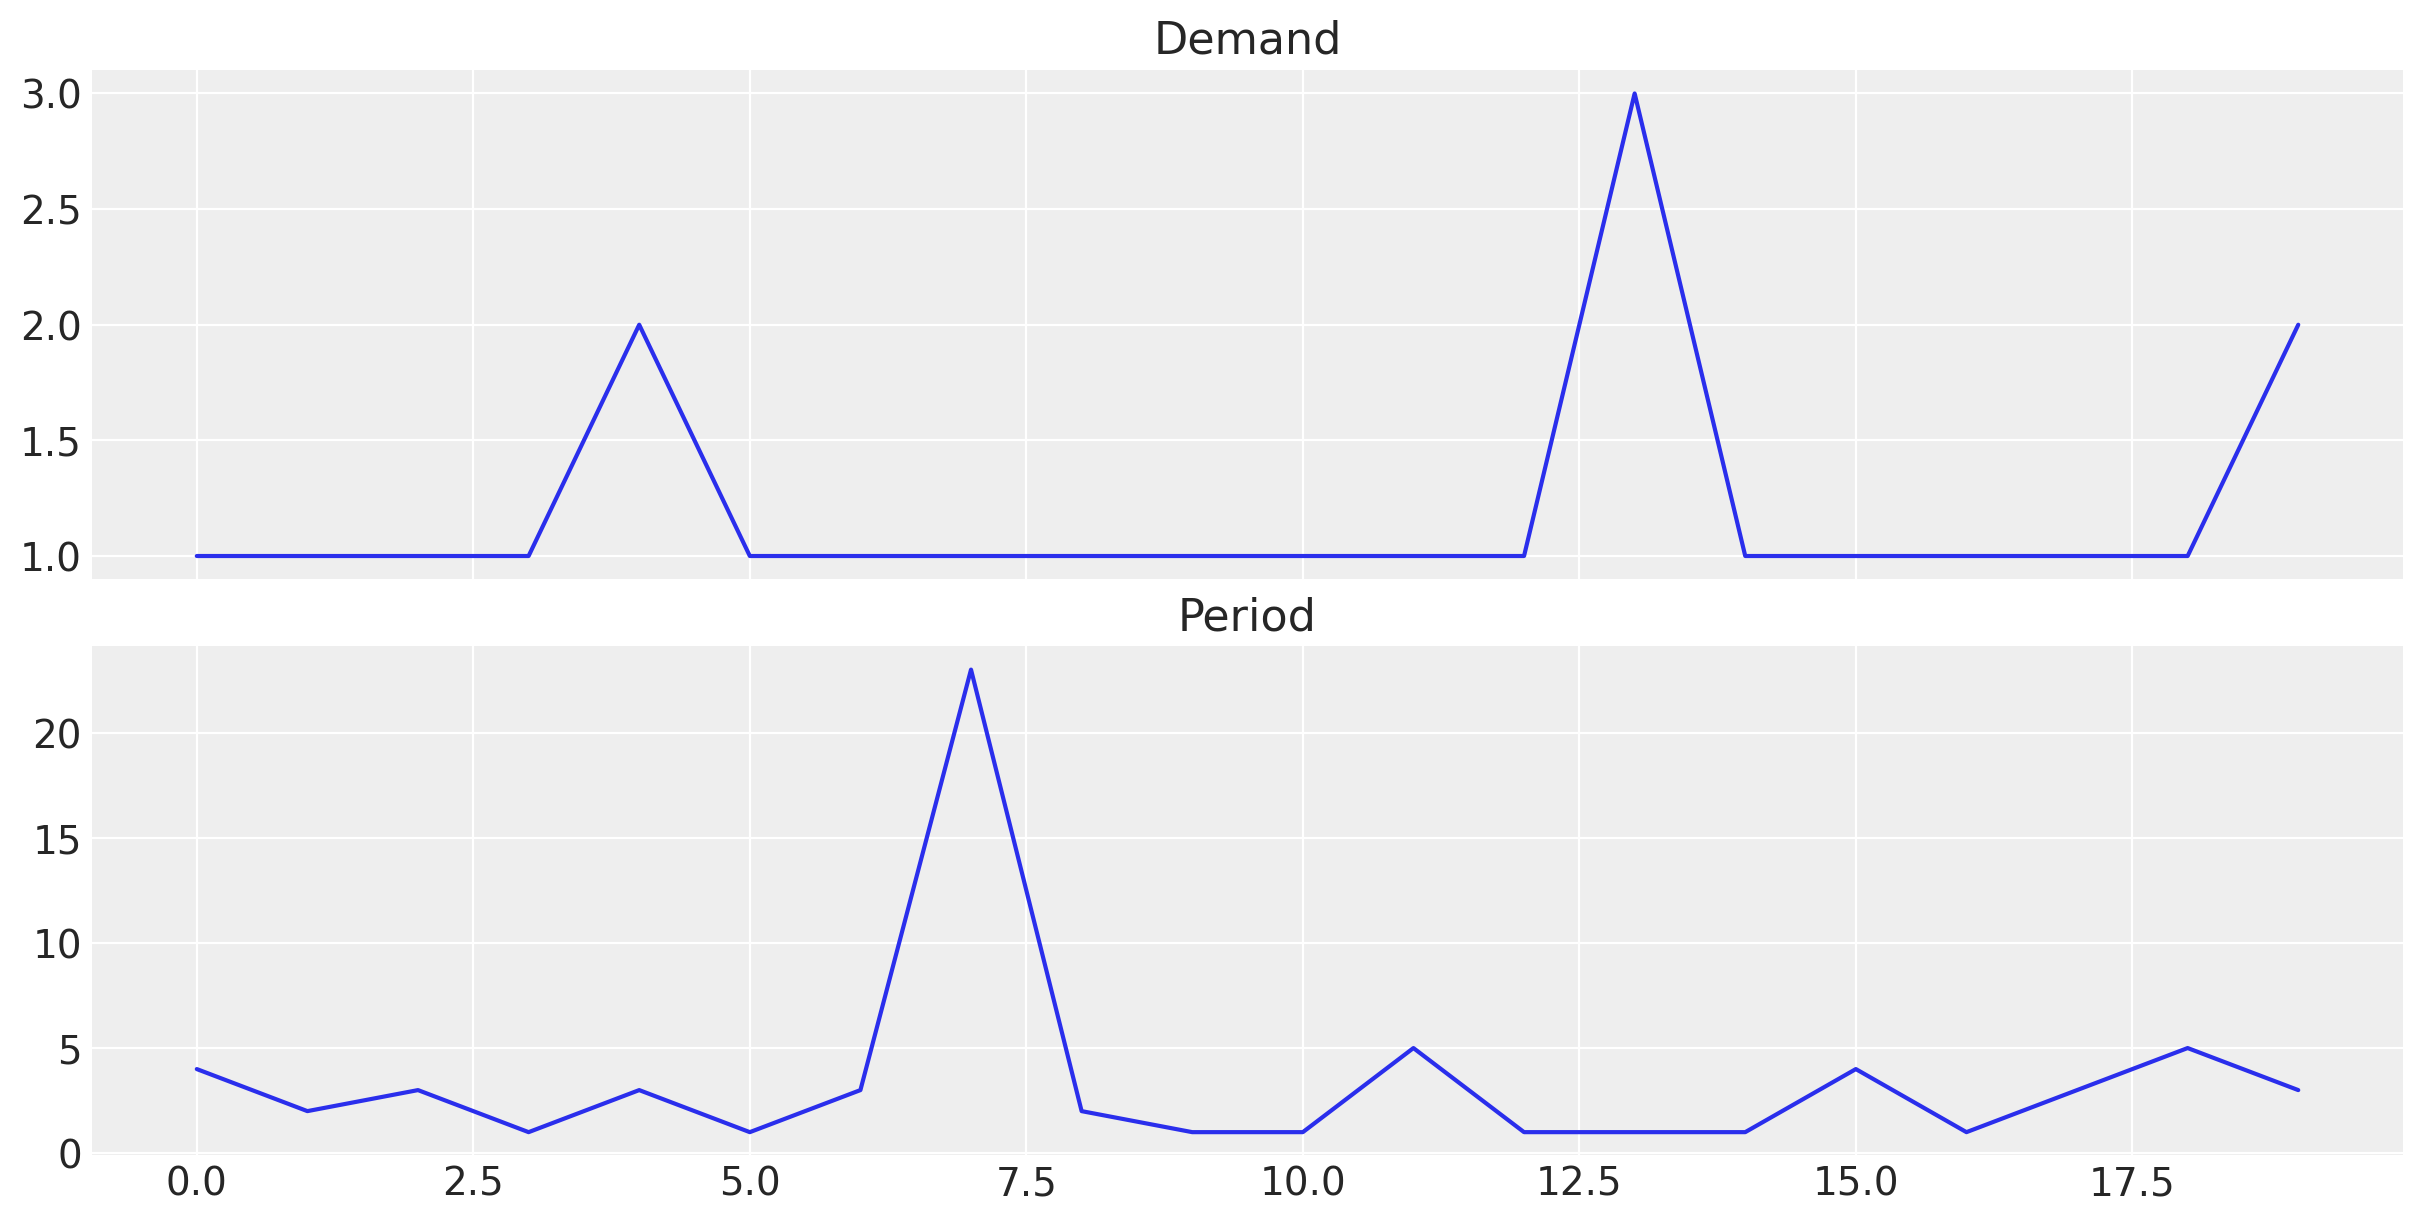

In [7]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 6), sharex=True, sharey=False, layout="constrained"
)
ax[0].plot(z)
ax[0].set_title("Demand")
ax[1].plot(p)
ax[1].set_title("Period")

In [17]:
def level_model(ts: ArrayImpl, future: int = 0) -> None:
    t_max = ts.size

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])

In [25]:
def croston_model(z: ArrayImpl, p: ArrayImpl, future: int = 0) -> None:
    z_forecast = scope(level_model, "demand")(z, future)
    p_forecast = scope(level_model, "period")(p, future)

    if future > 0:
        return numpyro.deterministic("forecast", z_forecast / p_forecast)

In [26]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [27]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, croston_model, inference_params, z, p)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [28]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
demand/level_init,1.304,0.195,0.965,1.683,0.003,0.002,4969.0,3854.0,1.0
demand/level_smoothing,0.024,0.039,0.000,0.061,0.001,0.000,3995.0,3211.0,1.0
demand/noise,0.585,0.111,0.404,0.790,0.002,0.001,6274.0,4902.0,1.0
period/level_init,0.980,1.136,-1.154,2.996,0.019,0.013,3685.0,5492.0,1.0
period/level_smoothing,0.320,0.291,0.000,0.855,0.005,0.003,3559.0,5061.0,1.0
period/noise,4.097,0.430,3.305,4.914,0.006,0.004,5524.0,4989.0,1.0


In [29]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Croston Model Trace')

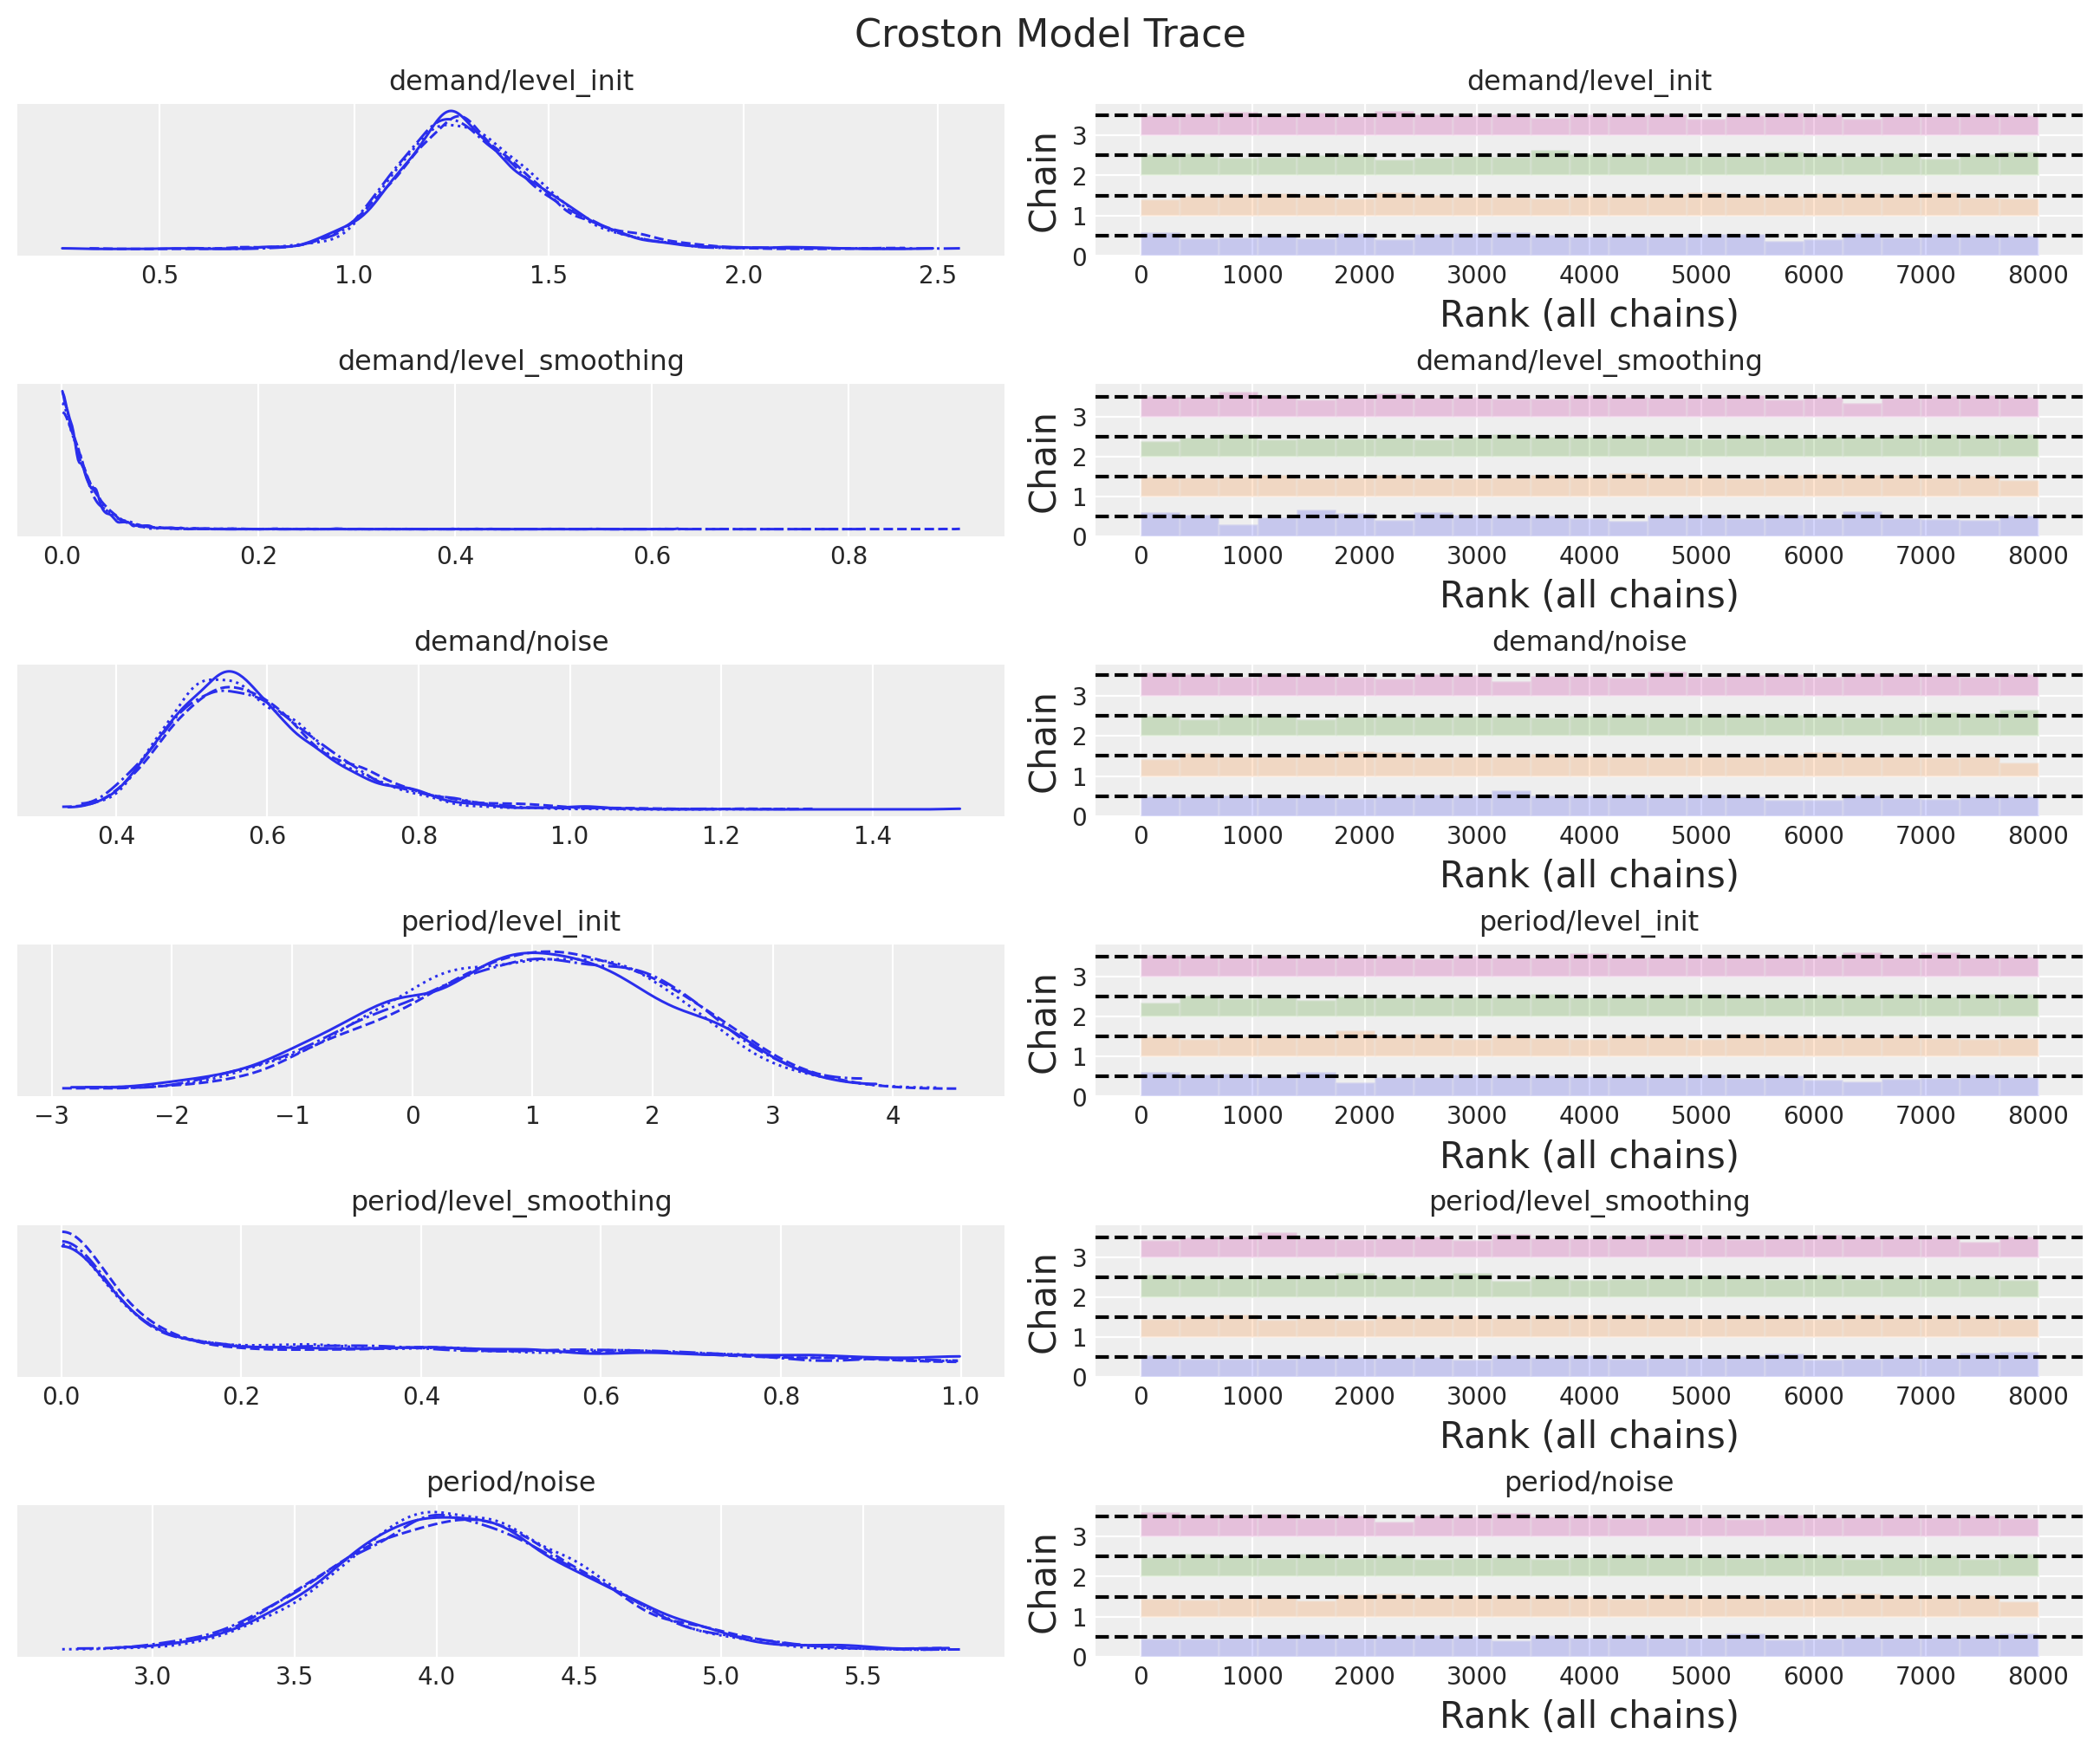

In [30]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Croston Model Trace", fontsize=16)

In [31]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["forecast"],
    )
    return predictive(rng_key, *model_args)

In [32]:
rng_key, rng_subkey = random.split(key=rng_key)
croston_forecast = forecast(
    rng_subkey, croston_model, mcmc.get_samples(), z, p, y_test.size
)

In [33]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=croston_forecast,
    coords={"t": t_test},
    dims={"forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

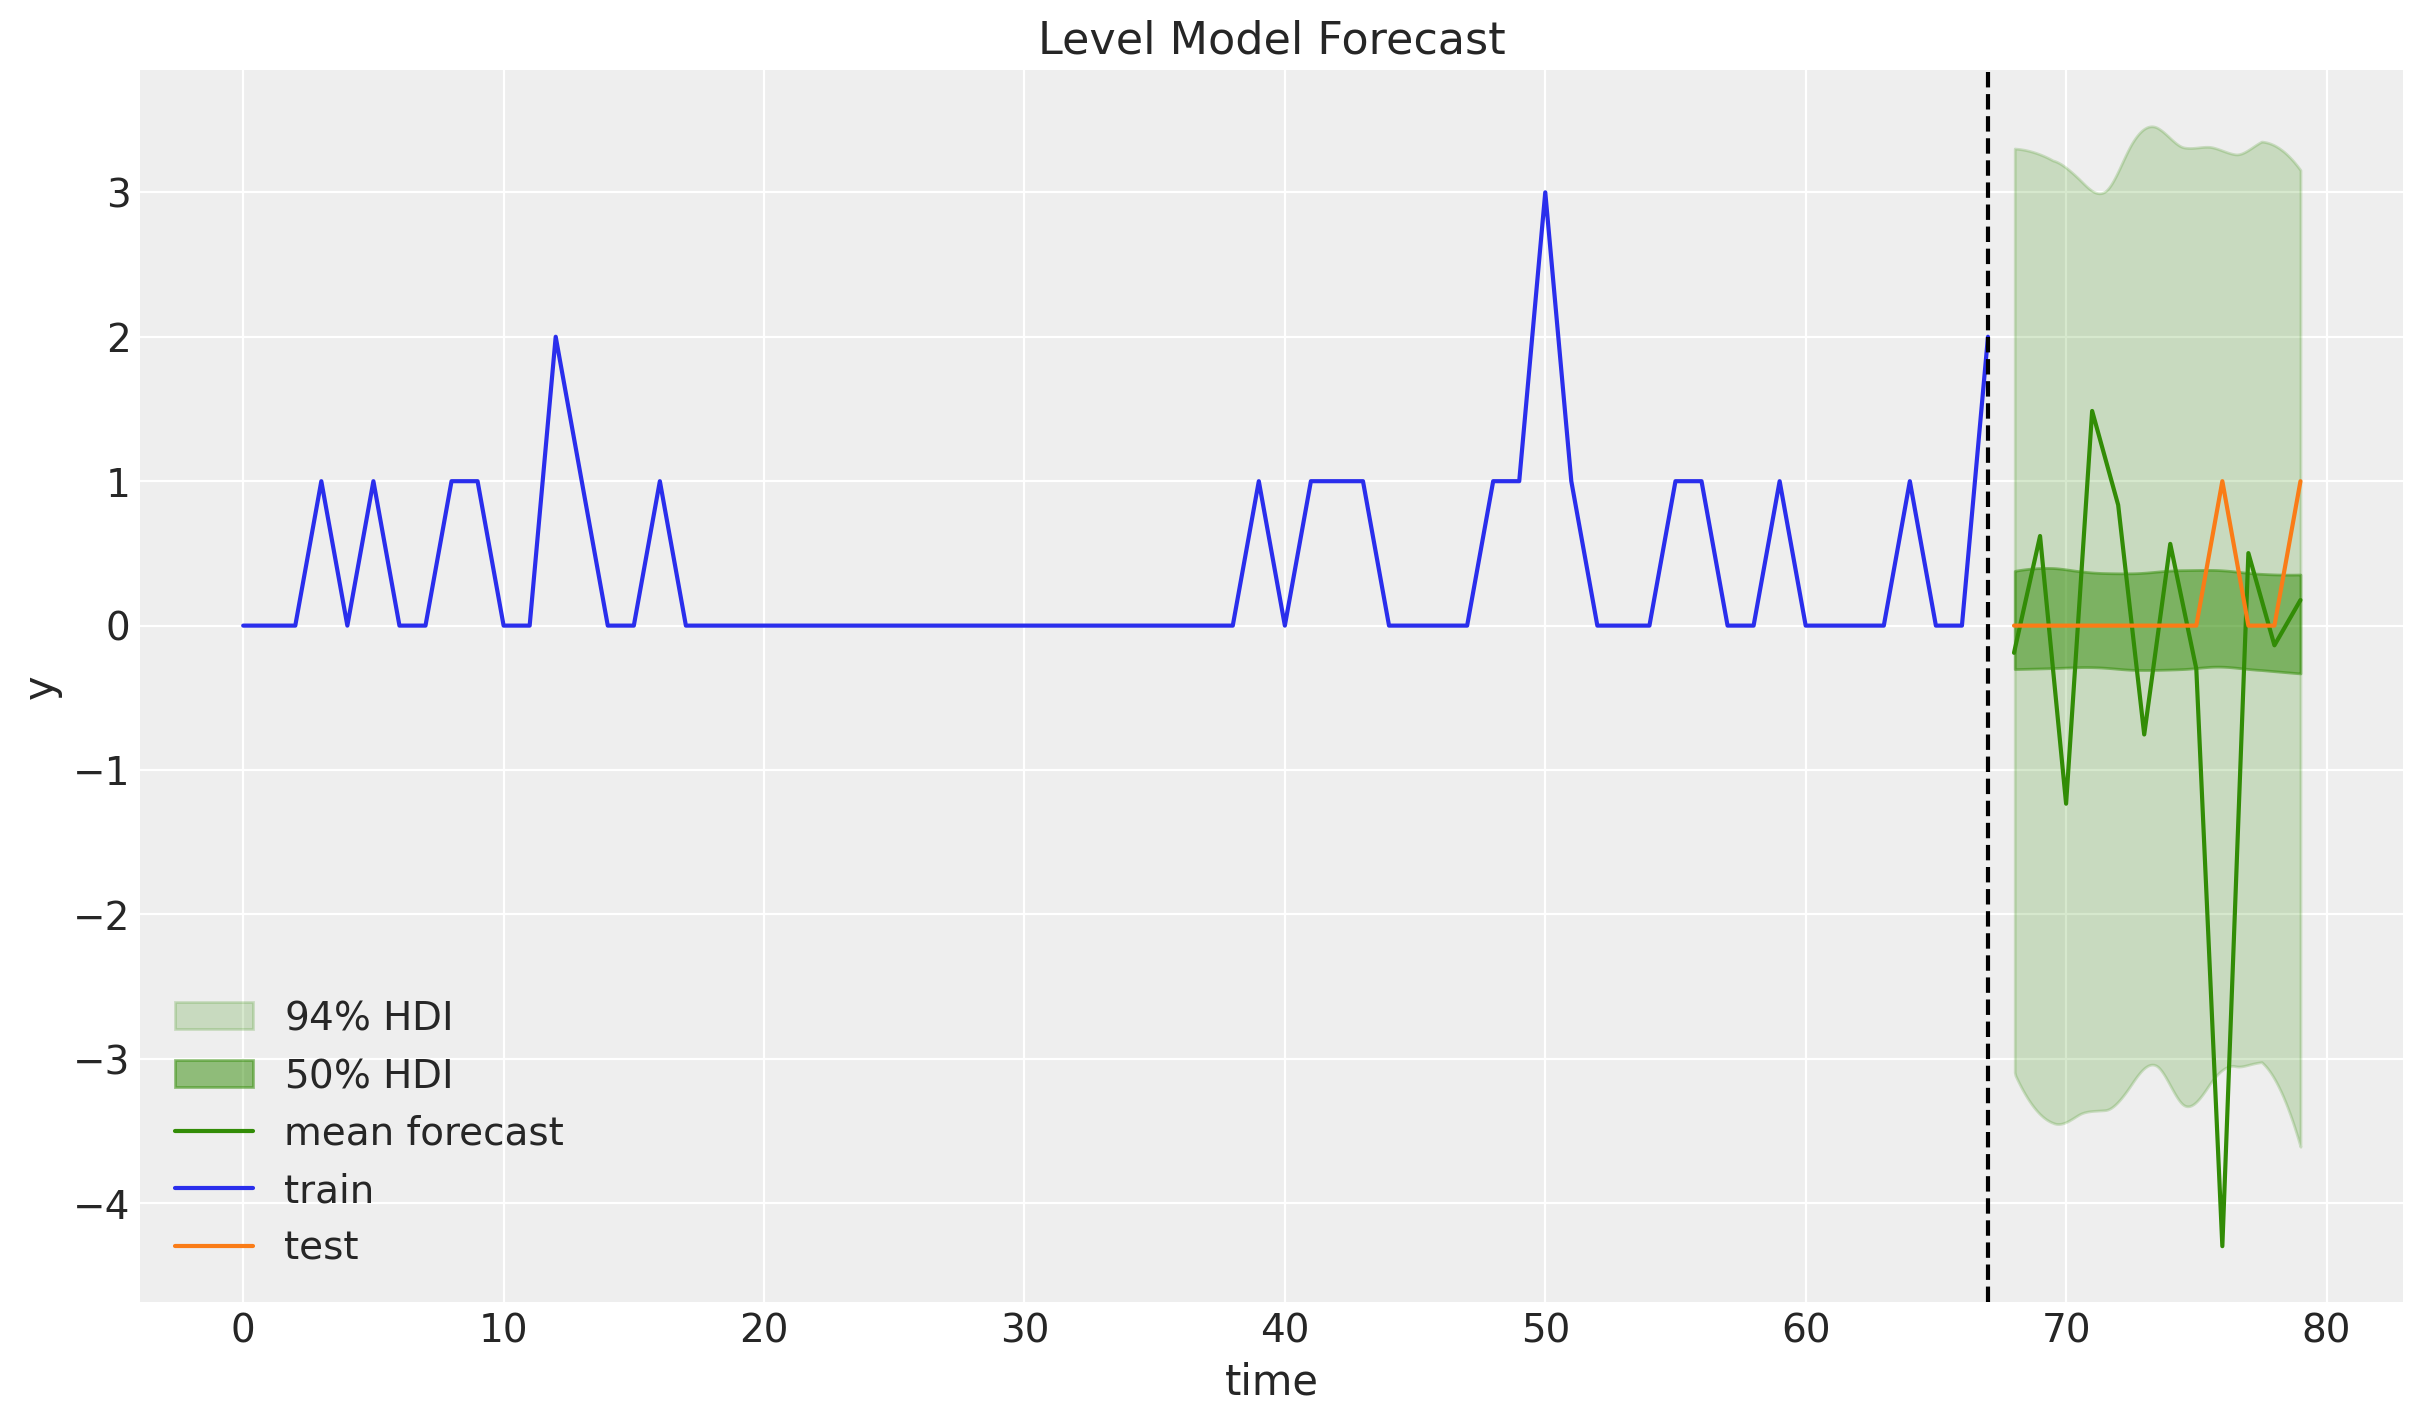

In [34]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")